## 1. Preprocess

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data
cn = pd.read_csv("./data/concentration/2020_20230814.csv").dropna()
q = pd.read_csv("./data/quote/2020_20230814.csv").dropna()

In [3]:
# mutate col
df = pd.merge(q, cn, on=['日期', '股號'], how='left')
df = df.groupby('股號').apply(lambda x: x.sort_values('日期')).reset_index(drop=True)


# 量起
df['成交量_1'] = df.groupby('股號')['成交量'].shift(-1)

def divide_two_cols(df_sub):
    df_sub['volume_delta_1'] = df_sub['成交量_1'] / df_sub['成交量']
    return df_sub

df = df.groupby('股號').apply(divide_two_cols)


# 價揚
# shift 1 假設是成交量出現異常後的下一根進場
df['ret'] = df.groupby('股號')['收盤價'].pct_change()
df['ret_2'] = df.groupby('股號')['ret'].shift(-1)
df = df.dropna()

In [4]:
# choose 1101 
df_1101 = df[df['股號']==4569]


vol_increase_id = df_1101[(df_1101['成交量']>500)&(df_1101['volume_delta_1']>2)].index
df_1101['indicator'] = df_1101.index.isin(vol_increase_id).astype(int)
df_1101['abnormal'] = (df_1101['indicator'].shift(1) == 0) & (df_1101['indicator'] == 1)

df_1101 = df_1101.dropna()

In [14]:
df_1101

,日期,股號,收盤價,漲跌幅(%),成交量,成交值(百萬),主力買賣超,散戶買賣超,5日籌碼集中度,成交量_1,volume_delta_1,ret,ret_2,indicator,abnormal
854903,2023-08-01,4569,115.0,-1.29,378,44.76,-30.0,85.0,-8.14,390.0,1.031746,-0.012876,-0.069565,0,False
854904,2023-08-02,4569,107.0,-6.96,390,42.79,-43.0,74.0,-9.44,223.0,0.571795,-0.069565,-0.051402,0,False
854905,2023-08-04,4569,101.5,-5.14,223,22.94,-58.0,75.0,-10.64,175.0,0.784753,-0.051402,-0.009852,0,False
854906,2023-08-07,4569,100.5,-0.99,175,17.42,11.0,-23.0,-8.82,141.0,0.805714,-0.009852,-0.027861,0,False
854907,2023-08-08,4569,97.7,-2.79,141,13.87,-1.0,30.0,-7.92,53.0,0.375887,-0.027861,-0.004094,0,False
854908,2023-08-09,4569,97.3,-0.41,53,5.18,3.0,0.0,-6.04,74.0,1.396226,-0.004094,0.014388,0,False
854909,2023-08-10,4569,98.7,1.44,74,7.36,-4.0,5.0,-0.81,76.0,1.027027,0.014388,-0.031408,0,False
854910,2023-08-11,4569,95.6,-3.14,76,7.41,7.0,-3.0,9.41,207.0,2.723684,-0.031408,-0.075314,0,False


In [5]:
# pd.set_option('display.max_rows', None)
# df_1101
# df_1101.head()

In [6]:
# def get_indcum(col_ret, col_abnormal, num_period):

#     res = []
#     i = 0

#     while i <= len(col_abnormal)-num_period+1:
#         # print(i)
#         tmp_sig = col_abnormal[i:i+num_period]
#         tmp_ret = col_ret[i:i+num_period]

#         if tmp_sig.iloc[0]==True:
#             res.extend(list(np.cumprod(1 + tmp_ret.values) - 1))
#             # print(list(np.cumprod(1 + tmp_ret.values) - 1))
#             i += num_period
#             next

#         else: 
#             # print(tmp_ret.iloc[0])
#             res.append(tmp_ret.iloc[0])
#             i += 1
            
#     if i > len(col_abnormal)-num_period+1:
#         # res.extend(tmp_ret)
#         print(len(col_ret[i:]))
#         res.extend(col_ret[i:])

#     return res

In [9]:
def get_indcum(col_ret, col_abnormal, num_period):

    res_p = []
    res = []
    i = 0

    while i <= len(col_abnormal)-num_period+1:
        tmp_sig = col_abnormal[i:i+num_period]
        tmp_ret = col_ret[i:i+num_period]

        if tmp_sig.iloc[0]==True:
            res.extend(list(np.cumprod(1 + tmp_ret.values) - 1))
            res_p.append(list(np.cumprod(1 + tmp_ret.values) - 1))
            # print(list(np.cumprod(1 + tmp_ret.values) - 1))
            i += num_period
            next

        else: 
            # print(tmp_ret.iloc[0])
            res.append(tmp_ret.iloc[0])
            i += 1
            
    if i > len(col_abnormal)-num_period+1:
        if tmp_sig.iloc[0]==True:
            res.extend(list(np.cumprod(1 + col_abnormal[i:].values) - 1))
            res_p.append(list(np.cumprod(1 + col_abnormal[i:].values) - 1))
        else:
        # res.extend(tmp_ret)
        # print(len(col_ret[i:]))
            res.extend(col_ret[i:])

    return res, res_p

In [13]:
df_1101['ret_2']
# n_p = 10
# c, cp = get_indcum(col_ret = df_1101['ret_2'], col_abnormal=df_1101['abnormal'], num_period=n_p)
# df_1101[f'cumret_{n_p}'] = c

854903   -0.069565
854904   -0.051402
854905   -0.009852
854906   -0.027861
854907   -0.004094
854908    0.014388
854909   -0.031408
854910   -0.075314
Name: ret_2, dtype: float64

## 2. Analysis

定義成交量異常為事件，對股票價格進行經濟與統計上面的分析


<!-- 價揚的定義
- 2.1 CAR (累積異常報酬的統計檢定) -->

### 2.1 Event Study Methodology

- window : 10 
- abnormal return : 

### 2.2 t-test

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import wilcoxon

#### 2.2.1 全部一起看
H0 : 平均數為0<br>
H1 : not H0

窗格可能要搜尋

In [ ]:
ret = df_1101[(df_1101[f'cumret_{n_p}']) != (df_1101['ret_2'])]['ret_2']

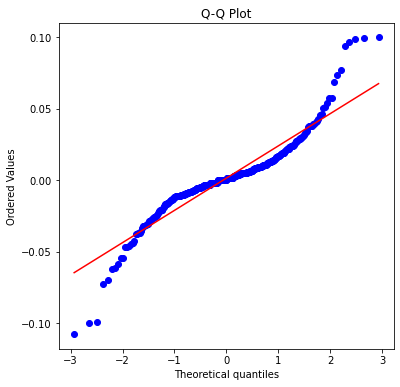

Shpiro test, statistics : nan / p-value : 1.0
wilcoxon, statistics : 38587.5 / p-value : 0.10196624977423265 / zero_method : pratt
wilcoxon, statistics : 33727.5 / p-value : 0.09905841780754754 / zero_method : wilcox
wilcoxon, statistics : 38776.5 / p-value : 0.10200472700695408 / zero_method : zsplit


In [ ]:
# Create Q-Q plot
plt.figure(figsize=(6, 6))
probplot(ret, dist='norm', plot=plt)
plt.title('Q-Q Plot')
plt.show()


# normal test 
stat, p_value = shapiro(np.log(ret))
print(f'Shpiro test, statistics : {stat} / p-value : {p_value}')


# Wilcoxon signed-rank test
m = ['pratt', 'wilcox', 'zsplit']
for i in m:
    stat, p_value = wilcoxon(ret, zero_method=i)
    print(f'wilcoxon, statistics : {stat} / p-value : {p_value} / zero_method : {i}')

#### 2.2.2 分異常訊號看
基本接顯著

In [ ]:
import itertools
critical = 0.05
# m = ['pratt', 'wilcox', 'zsplit']
cp = list(k for k,_ in itertools.groupby(cp))

for i, l in enumerate(cp):
    # print(i, l)
    # for j in m:
    if len(l)>1:
        stat, p_value = wilcoxon(l)
        if p_value <critical: 
            # print(f'wilcoxon, statistics : {stat} / p-value : {p_value} / zero_method : {j}')
            print(f'wilcoxon, statistics : {stat} / p-value : {p_value} ')
            print('==================================\n')


wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 3.0 / p-value : 0.009765625 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 3.0 / p-value : 0.009765625 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 1.0 / p-value : 0.00390625 

wilcoxon, statistics : 3.0 / p-value : 0.009765625 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 0.0 / p-value : 0.007685794055213263 

wilcoxon, statistics : 2.0 / p-value : 0.005859375 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 6.0 / p-value : 0.02734375 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 0.0 / p-value : 0.001953125 

wilcoxon, statistics : 1.0 / p-value : 0.00390625 

wilcoxon, statistics : 0.0 / p-value : 0

### 2.3 Monotonic Trend test

#### 2.3.1 分異常訊號看

In [ ]:
_, cp = get_indcum(col_ret = df_1101['cumret_10'], col_abnormal=df_1101['abnormal'], num_period=n_p)


import pymannkendall as mk


for l in cp:
    if len(l) > 1:
        trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test(l)
        print(trend)

decreasing
decreasing
increasing
increasing
increasing
increasing
decreasing
decreasing
decreasing
increasing
decreasing
increasing
increasing
decreasing
increasing
increasing
increasing
decreasing
increasing
increasing
decreasing
no trend
no trend
decreasing
decreasing
increasing
decreasing
decreasing
decreasing
decreasing
increasing
no trend
decreasing
increasing
increasing
increasing
increasing
decreasing
increasing
increasing
increasing
increasing
increasing
increasing
increasing
decreasing


### 2.4 None monotonic Trend test

### 2.5 Regression